In [34]:
import typing
import gc
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

import matplotlib.pyplot as plt

In [204]:
# no magic numbers :)
train_split = .6
valid_split = .2
test_split = .2

# paramaters for data generation
n = 10000
p = 100
len_y = 1000
x_rank = 1 # weird number... works if <1, bur is described as an integer!?
train_split_idx = int(n//(1/train_split) + 1)
valid_split_idx = int(train_split_idx + n//(1/valid_split))

In [205]:
train_split_idx, valid_split_idx

(6000, 8000)

In [206]:
data = make_regression(n_samples = n, 
                       n_features = p, 
                       n_informative = p, 
                       n_targets = len_y, 
                       effective_rank = x_rank, 
                       noise = .1,
                       random_state = 123)

Visualise the data by plotting a random feature, and check compressibility

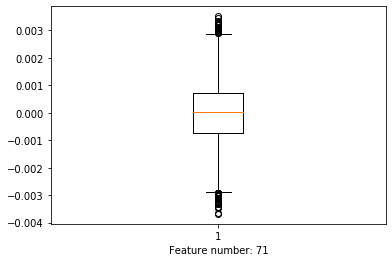

In [207]:
idx = np.random.randint(0, X_valid.shape[1])
plt.boxplot(data[0][:,idx]);
plt.xlabel("Feature number: {}".format(idx));

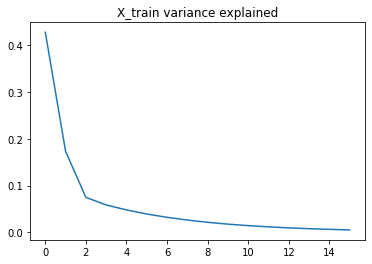

In [208]:
pca = PCA(n_components=16)
plt.plot( pca.fit(data[0]).explained_variance_ratio_ )
plt.title("X_train variance explained");

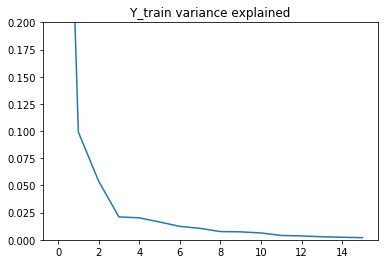

In [211]:
plt.plot( pca.fit(data[1]).explained_variance_ratio_ )
plt.title("Y_train variance explained");
plt.ylim(0, 0.2);

In [212]:
X_train, X_valid, X_test = (
    data[0][:train_split_idx, :], 
    data[0][train_split_idx:valid_split_idx, :],
    data[0][valid_split_idx:, :])
Y_train, Y_valid, Y_test = (
    data[1][:train_split_idx, :], 
    data[1][train_split_idx:valid_split_idx, :],
    data[1][valid_split_idx:, :])

In [214]:
alphas = np.linspace(10e-5, 10e-3, num=10)
valid_losses = []
for alpha in alphas:
    print("Computing validation loss for alpha = {}".format(alpha))
    lasso_model = Lasso(alpha).fit(X_train, Y_train)
    Y_hat = lasso_model.predict(X_valid)
    valid_losses.append(mean_squared_error(Y_hat, Y_valid))

Computing validation loss for alpha = 0.0001
Computing validation loss for alpha = 0.0012000000000000001
Computing validation loss for alpha = 0.0023
Computing validation loss for alpha = 0.0034
Computing validation loss for alpha = 0.0045000000000000005
Computing validation loss for alpha = 0.005600000000000001
Computing validation loss for alpha = 0.0067
Computing validation loss for alpha = 0.0078000000000000005
Computing validation loss for alpha = 0.0089
Computing validation loss for alpha = 0.01


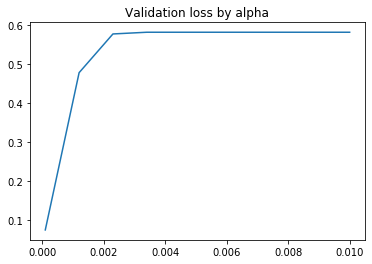

In [215]:
# plot losses
plt.plot(alphas, valid_losses)
plt.title("Validation loss by alpha")
plt.show()

In [216]:
lasso_model = Lasso(alphas[np.argmin(valid_losses)]).fit(X_train, Y_train)

Look at the model coefficients

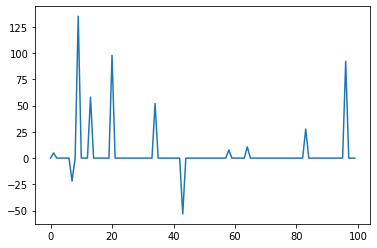

In [217]:
plt.plot(lasso_model.coef_[1])

In [218]:
Y_hat = lasso_model.predict(X_valid)

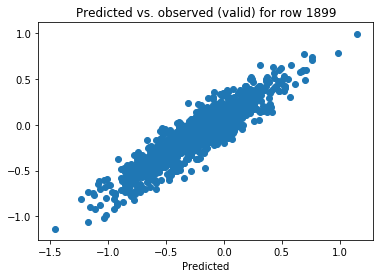

In [219]:
# plot predicted vs. observed for a random row
idx = np.random.randint(0, X_valid.shape[0])
plt.scatter(Y_valid[idx], Y_hat[idx])
plt.xlabel("Observed")
plt.xlabel("Predicted")
plt.title("Predicted vs. observed (valid) for row {}".format(idx));

In [220]:
Y_hat = lasso_model.predict(X_test)
print("Final test loss (mse): {}".format(mean_squared_error(Y_hat, Y_test)))

Final test loss (mse): 0.07288231961905746
